# 梯度提升決策樹回歸(Gradient Boost Decision Tree Regressor)

##### 先引入我們需要的packages`

In [1]:
import os 
import numpy as np
import random
import matplotlib.pyplot as plt
from random import choices

# Training Data

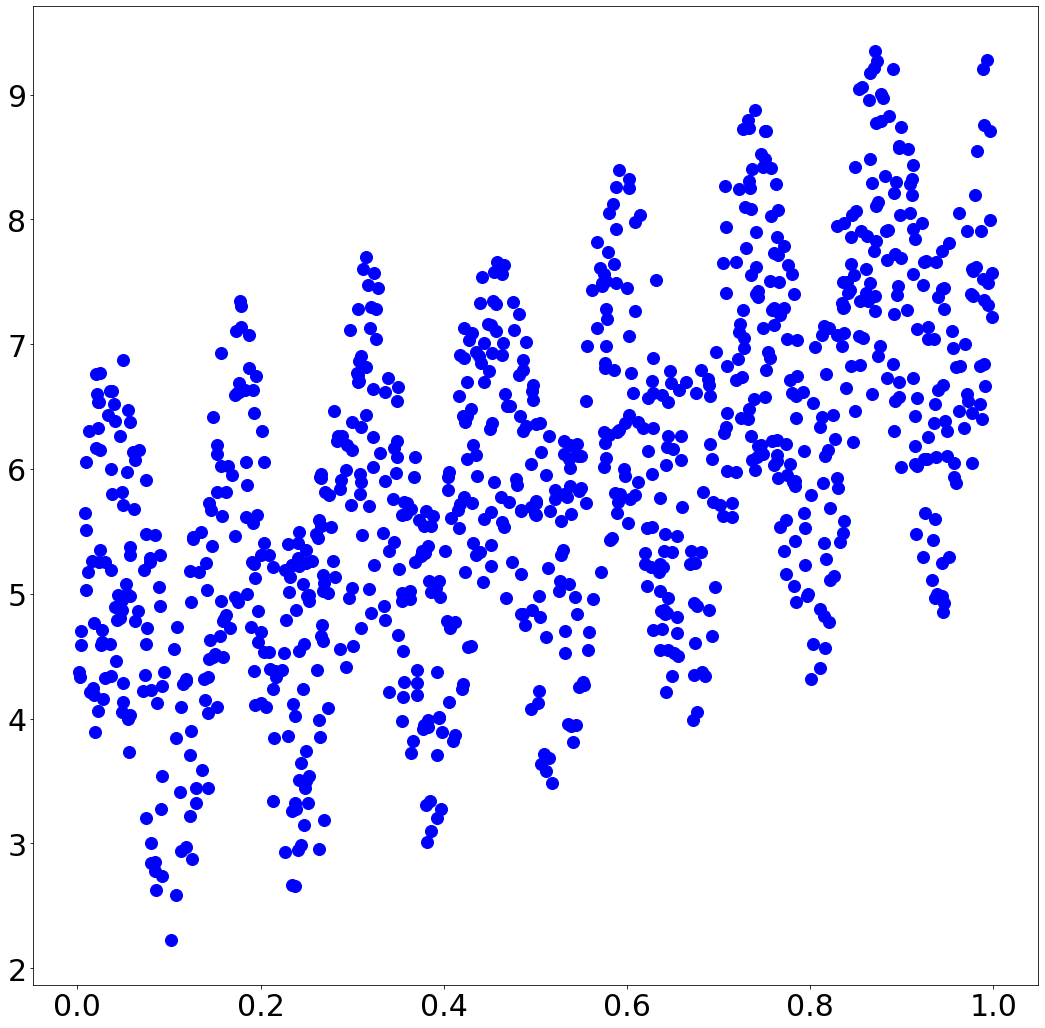

In [2]:
"""
產生我們的訓練集資料
這裡我們使用二次函數+sin函數
"""
N=1000
p2,p1,p0=1,2,3
x=np.zeros(N)
y=np.zeros(N)
for i in range(0,len(x)):
    x[i]+=random.random()
    y[i]+=random.random()*3
power=[p2,p1,p0]
for i in range(0,len(power)):
    y+=power[len(power)-i-1]*(x**i)
y+=np.sin(x*45)
plt.rcParams["figure.figsize"] = (18,18)
plt.plot(x,y,"bo",markersize=12)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

# Testing Data

In [3]:
N_test=50
x_test=np.zeros(N_test)
y_test=np.zeros(N_test)
for i in range(0,len(x_test)):
    x_test[i]+=random.random()
    y_test[i]+=random.random()*3
power=[p2,p1,p0]
for i in range(0,len(power)):
    y_test+=power[len(power)-i-1]*(x_test**i)
y_test+=np.sin(x_test*45)

# Decision Stump

In [4]:
def Decision_Stump(x,y):
    """
    comp: 用來放MSE候選值
    sort: 所有資料點數值排序
    sort_index: 所有資料點數值排序後所對應的index
    """
    comp=np.zeros(len(y)-1)
    sort=np.sort(x)
    sort_index=np.argsort(x)
    for i in range(1,len(y)):
        s_left,s_right=sort_index[:i],sort_index[i:]
        left_temp=(len(s_left)/len(y))*sum((y[s_left]-np.mean(y[s_left]))**2)
        right_temp=(len(s_right)/len(y))*sum((y[s_right]-np.mean(y[s_right]))**2)
        comp[i-1]=left_temp+right_temp
    x_split=(sort[np.argmin(comp)]+sort[np.argmin(comp)+1])/2
    return x_split,min(comp)

# Decision Tree Algorithms

In [5]:
def Decision_Tree(x,y,x_real,y_real,x_test,y_test,index,index_test,max_depth,y_train,y_pred):
    """
    x: 輸入訓練資料(長度隨遞迴深度改變)
    y: 輸出訓練資料(長度隨遞迴深度改變)
    x_real: 輸入訓練資料(真實數據)
    y_real: 輸出訓練資料(真實數據)
    x_test: 輸入測試資料
    y_test: 輸出測試資料
    index: 當前輸入到決策樹演算法中的訓練資料編號
    index_test: 當前輸入到決策樹演算法中的測試資料編號
    max_depth: 最大決策樹深度
    y_train: 於訓練集所預測的輸出值
    y_pred: 於測試集所預測的輸出值
    color: 回歸線的顏色
    """
    """
    執行Decision Stump演算法算出最佳分割線
    得到第m特徵的分割線座標x_split後
    以x_split和m將訓練Decision Tree的訓練資料(隨機選取的)分成left和right兩部分
    """
    x_split,impurity=Decision_Stump(x,y)
    p=x<x_split
    x_left,y_left=x[p],y[p]
    x_right,y_right=x[~p],y[~p]
    """
    接著我們一樣以x_split，拆分我們的真實訓練資料和測試資料，所以這裡
    left_index和right_index分別代表在此Node的之下
    真實訓練資料分到左邊subtree的index和分到右邊subtree的index
    left_index_test和right_index_test分別代表在此Node的之下
    測試資料分到左邊subtree的index和分到右邊subtree的index
    """
    p_real=x_real<x_split
    p_real_left=np.where(p_real)
    p_real_right=np.where(~p_real)
    left_index=np.intersect1d(p_real_left,index)
    right_index=np.intersect1d(p_real_right,index)
    p_test=x_test<x_split
    p_test_left=np.where(p_test)
    p_test_right=np.where(~p_test)
    left_index_test=np.intersect1d(p_test_left,index_test)
    right_index_test=np.intersect1d(p_test_right,index_test)
    """
    檢查左右兩邊的subtree是否只剩下一筆或是輸出資料y都相同
    """
    check_left,check_right=True,True
    if(len(y_left)!=1):
        for i in range(1,len(y_left)):
            if(y_left[i]!=y_left[0]):
                check_left=False
                break
    if(len(y_right)!=1):
        for i in range(1,len(y_right)):
            if(y_right[i]!=y_right[0]):
                check_right=False
                break
    """
    <Condiction>
    (sel==0)
    -->代表當前Node底下的兩個subtree都完美回歸MSE=0，或是已達到所限制的最大層數
    (sel==1)
    -->代表當前Node底下的兩個subtree都還沒分完
    (sel==2)
    -->代表當前Node底下，右邊的subtree已完美回歸MSE=0，但是左邊的subtree還沒分完
    (sel==3)
    -->代表當前Node底下，左邊的subtree已完美回歸MSE=0，但是右邊的subtree還沒分完
    """
    if((impurity==0)or(max_depth==0)or((check_left)and(check_right))):
        y_train[left_index],y_train[right_index]=np.mean(y_left),np.mean(y_right)
        y_pred[left_index_test],y_pred[right_index_test]=np.mean(y_left),np.mean(y_right)
        return y_train,y_pred
    elif(check_left):
        max_depth-=1
        y_train,y_pred=Decision_Tree(x_right,y_right,x_real,y_real,x_test,y_test,
                                     right_index,right_index_test,max_depth,y_train,y_pred)
        y_train[left_index]=np.mean(y_left)
        y_pred[left_index_test]=np.mean(y_left)
        return y_train,y_pred
    elif(check_right):
        max_depth-=1
        y_train,y_pred=Decision_Tree(x_left,y_left,x_real,y_real,x_test,y_test,
                                     left_index,left_index_test,max_depth,y_train,y_pred)
        y_train[right_index]=np.mean(y_right)
        y_pred[right_index_test]=np.mean(y_right)
        return y_train,y_pred
    else:
        max_depth-=1
        y_train,y_pred=Decision_Tree(x_left,y_left,x_real,y_real,x_test,y_test,
                                     left_index,left_index_test,max_depth,y_train,y_pred)
        y_train,y_pred=Decision_Tree(x_right,y_right,x_real,y_real,x_test,y_test,
                                     right_index,right_index_test,max_depth,y_train,y_pred)
        return y_train,y_pred

# Decision Tree Algorithms for Gradient Boosting

In [6]:
def GB_Decision_Tree(x,r,x_real,x_test,index,index_test,max_depth,delta,res,res_test):
    """
    x: 輸入訓練資料(會隨遞迴深度改變數量)
    r: 輸出訓練資料(會隨遞迴深度改變數量)
    x_real: 輸入訓練資料
    x_test: 輸入測試資料
    index: 當前輸入到決策樹演算法中的訓練資料編號
    index_test: 當前輸入到決策樹演算法中的測試資料編號
    max_depth: 最大決策樹深度
    delta: 我們利用分位距求出的數值
    res: 用來畫分割區域的座標
    res_test: 於訓練集所預測的輸出值
    """
    """
    執行Decision Stump演算法算出最佳分割線
    以x_split和m將訓練Decision Tree的訓練資料(隨機選取的)分成left和right兩部分
    """
    x_split,impurity=Decision_Stump(x,r)
    p=x<x_split
    x_left,r_left=x[p],r[p]
    x_right,r_right=x[~p],r[~p]
    """
    接著我們一樣以x_split，拆分我們的真實訓練資料和測試資料，所以這裡
    left_index和right_index分別代表在此Node的之下
    真實訓練資料分到左邊subtree的index和分到右邊subtree的index
    left_index_test和right_index_test分別代表在此Node的之下
    測試資料分到左邊subtree的index和分到右邊subtree的index
    """
    p_real=x_real<x_split
    p_real_left=np.where(p_real)
    p_real_right=np.where(~p_real)
    left_index=np.intersect1d(p_real_left,index)
    right_index=np.intersect1d(p_real_right,index)
    p_test=x_test<x_split
    p_test_left=np.where(p_test)
    p_test_right=np.where(~p_test)
    left_index_test=np.intersect1d(p_test_left,index_test)
    right_index_test=np.intersect1d(p_test_right,index_test)
    """
    檢查左右兩邊的subtree是否只剩下一筆或是輸出資料r都相同
    """
    check_left,check_right=True,True
    if(len(r_left)!=1):
        for i in range(1,len(r_left)):
            if(r_left[i]!=r_left[0]):
                check_left=False
                break
    if(len(r_right)!=1):
        for i in range(1,len(r_right)):
            if(r_right[i]!=r_right[0]):
                check_right=False
                break
    """
    <Condiction>
    (sel==0)
    -->代表當前Node底下的兩個subtree都完美回歸MSE=0，或是已達到所限制的最大層數
    (sel==1)
    -->代表當前Node底下的兩個subtree都還沒分完
    (sel==2)
    -->代表當前Node底下，右邊的subtree已完美回歸MSE=0，但是左邊的subtree還沒分完
    (sel==3)
    -->代表當前Node底下，左邊的subtree已完美回歸MSE=0，但是右邊的subtree還沒分完
    """
    if((impurity==0)or(max_depth==0)or((check_left)and(check_right))):
        gamma_left=np.median(r_left)+sum(np.sign(r_left-np.median(r_left))*np.minimum(delta[left_index],abs(r_left-np.median(r_left))))/len(r_left)
        gamma_right=np.median(r_right)+sum(np.sign(r_right-np.median(r_right))*np.minimum(delta[right_index],abs(r_right-np.median(r_right))))/len(r_right)        
        res[left_index],res[right_index]=gamma_left,gamma_right
        res_test[left_index_test],res_test[right_index_test]=gamma_left,gamma_right
        return res,res_test
    elif(check_left):
        max_depth-=1
        res,res_test=GB_Decision_Tree(x_right,r_right,x_real,x_test,right_index,right_index_test,max_depth,delta,res,res_test)
        gamma_left=np.median(r_left)+sum(np.sign(r_left-np.median(r_left))*np.minimum(delta[left_index],abs(r_left-np.median(r_left))))/len(r_left)
        res[left_index]=gamma_left
        res_test[left_index_test]=gamma_left
        return res,res_test
    elif(check_right):
        max_depth-=1
        res,res_test=GB_Decision_Tree(x_left,r_left,x_real,x_test,left_index,left_index_test,max_depth,delta,res,res_test)
        gamma_right=np.median(r_right)+sum(np.sign(r_right-np.median(r_right))*np.minimum(delta[right_index],abs(r_right-np.median(r_right))))/len(r_right)        
        res[right_index]=gamma_right
        res_test[right_index_test]=gamma_right
        return res,res_test
    else:
        max_depth-=1
        res,res_test=GB_Decision_Tree(x_left,r_left,x_real,x_test,left_index,left_index_test,max_depth,delta,res,res_test)
        res,res_test=GB_Decision_Tree(x_right,r_right,x_real,x_test,right_index,right_index_test,max_depth,delta,res,res_test)
        return res,res_test

# Gradient Boosted Decision Tree

------------------------------------Decision Tree------------------------------------
The Decision Tree Training MSE: 0.7413845907682727  / Testing MSE: 0.9785816512810154


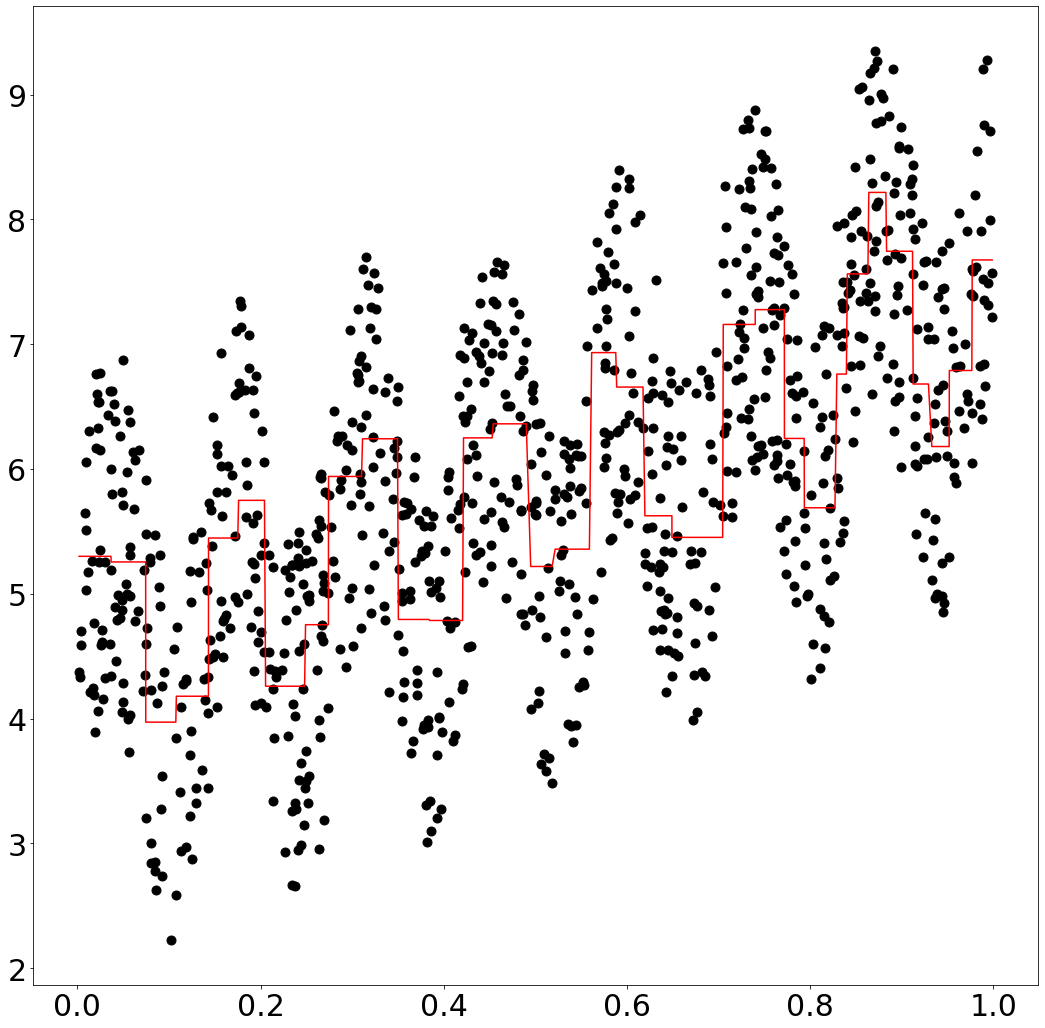

------------------------------------Gradient BoostedDecision Tree------------------------------------
The 1 iteration training MSE: 1.096519035752364 / testing MSE: 1.2231520466644352
The 2 iteration training MSE: 0.8401944024065098 / testing MSE: 1.0311115712925016
The 3 iteration training MSE: 0.7432726027188229 / testing MSE: 0.9252806852263461
The 4 iteration training MSE: 0.7125303728753489 / testing MSE: 0.8763227321587421
The 5 iteration training MSE: 0.701462437356683 / testing MSE: 0.8982513863283309
The 6 iteration training MSE: 0.6918547337743137 / testing MSE: 0.9250300116774064
The 7 iteration training MSE: 0.683770114504942 / testing MSE: 0.9287463485702503
The 8 iteration training MSE: 0.6773904998609246 / testing MSE: 0.9637270560604317
The 9 iteration training MSE: 0.6679411001135319 / testing MSE: 0.926581678086049
The 10 iteration training MSE: 0.6668881582180318 / testing MSE: 0.9294631849563442
The 11 iteration training MSE: 0.6631943072036721 / testing MSE: 0.9578

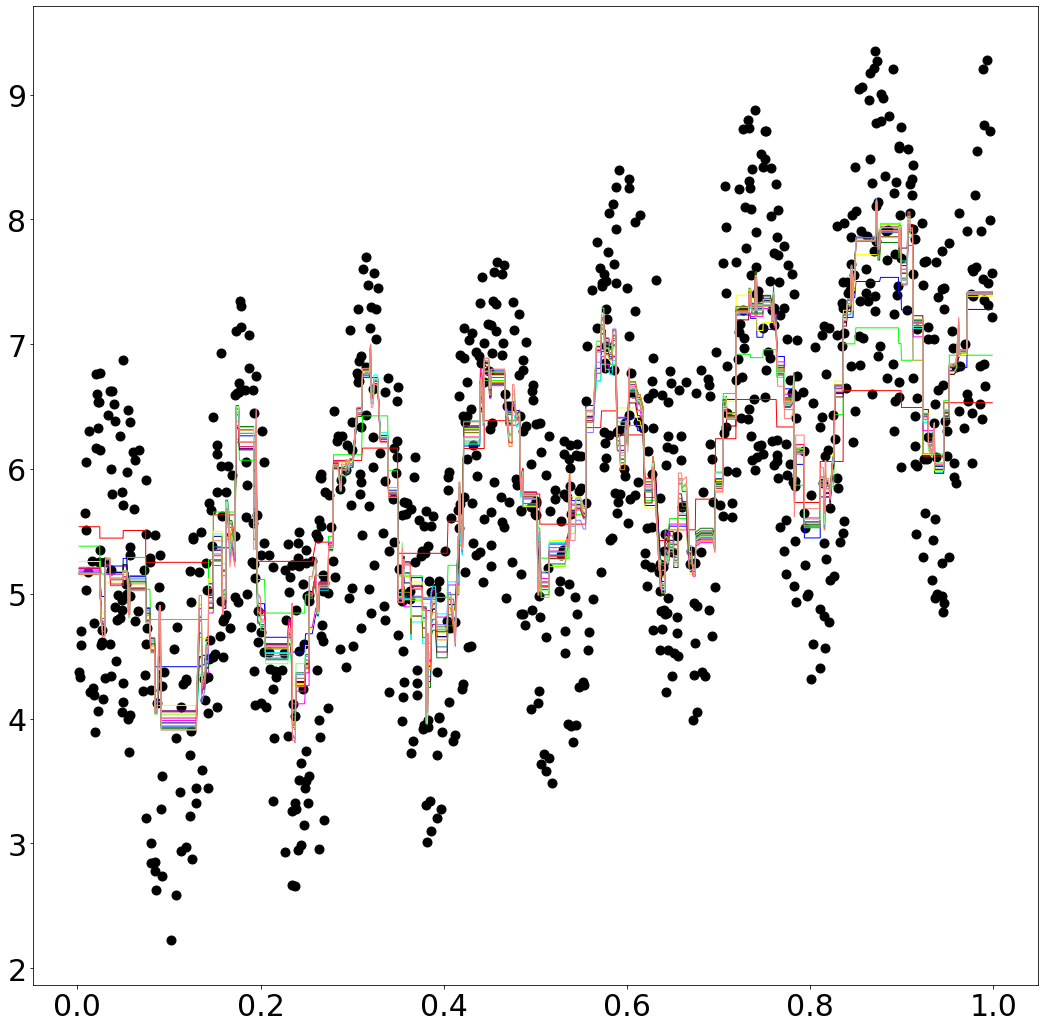

In [7]:
"""
Decision Tree
depth: 樹的深度
sort_x: 由小到大排序後的x
sort_x: 由小到大排序後的x對應的index
"""
y_train_DT=np.zeros(N)
y_pred_DT=np.zeros(N_test)
sort_x=np.sort(x)
sort_x_index=np.argsort(x)
depth=4
y_train_DT,y_pred_DT=Decision_Tree(x,y,x,y,x_test,y_test,np.where(y),np.where(y_test),
                                   depth,y_train_DT,y_pred_DT)
print("------------------------------------Decision Tree------------------------------------")
print("The Decision Tree Training MSE:",sum((y-y_train_DT)**2)/N,
      " / Testing MSE:",sum((y_test-y_pred_DT)**2)/N_test)
plt.rcParams["figure.figsize"] = (18,18)
plt.plot(x,y,"ko",markersize=9)
plt.plot(sort_x,y_train_DT[sort_x_index],"r",markersize=6)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()    
"""
Gradient Boosted Decision Tree
"""
print("------------------------------------Gradient BoostedDecision Tree------------------------------------")
"""
初始化我們的方程式F
T: 迴圈數
depth: 決策樹深度
color: 回歸線顏色
"""
F=np.zeros(N)+np.median(y)
F_test=np.zeros(N_test)+F[0]
T=18
sort_x=np.sort(x)
sort_x_index=np.argsort(x)
plt.rcParams["figure.figsize"] = (18,18)
plt.plot(x,y,"ko",markersize=9)
color=["#FF0000","#00FF00","#0000FF","#FFFF00","#FF00FF","#00FFFF",
       "#7F0000","#007F00","#00007F","#7F7F00","#7F007F","#007F7F",
       "#7FFF00","#FF7F00","#FF007F","#7F7FFF","#7FFF7F","#FF7F7F"]
"""
1. 計算殘差值
2. 宣告r_train存放訓練集的每筆數據相對應的預測殘差值
3. 宣告r_test存放測試集的每筆數據相對應的預測殘差值
4. 訓練decision tree regressor
5. 將F加上訓練集的預測殘差值
6. 將F_test加上測試集的預測殘差值
"""
for i in range(0,T):
    r=y-F
    delta=np.quantile(r, 0.7)
    BOOL=abs(r)<=delta
    r_r=np.zeros(N)
    r_r[BOOL]=r[BOOL]
    r_r[~BOOL]=delta*np.sign(r[~BOOL])
    delta_arr=np.ones(N)*delta
    res=np.zeros(N)
    res_test=np.zeros(N_test)
    res,res_test=GB_Decision_Tree(x,r_r,x,x_test,np.where(y),np.where(y_test),depth,delta_arr,res,res_test)
    F+=res
    F_test+=res_test
    print("The",i+1,"iteration training MSE:",sum((y-F)**2)/N,
          "/ testing MSE:",sum((y_test-F_test)**2)/N_test)
    plt.plot(sort_x,F[sort_x_index],color[i],linewidth=1)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()